In [72]:
from sqlalchemy import create_engine
from io import BytesIO
import requests
import pandas as pd
import os
import sqlalchemy
sqlite = create_engine('sqlite:///D:/files/Bankit.sqlite')
import sqlite3
import sys
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:,.0f}".format

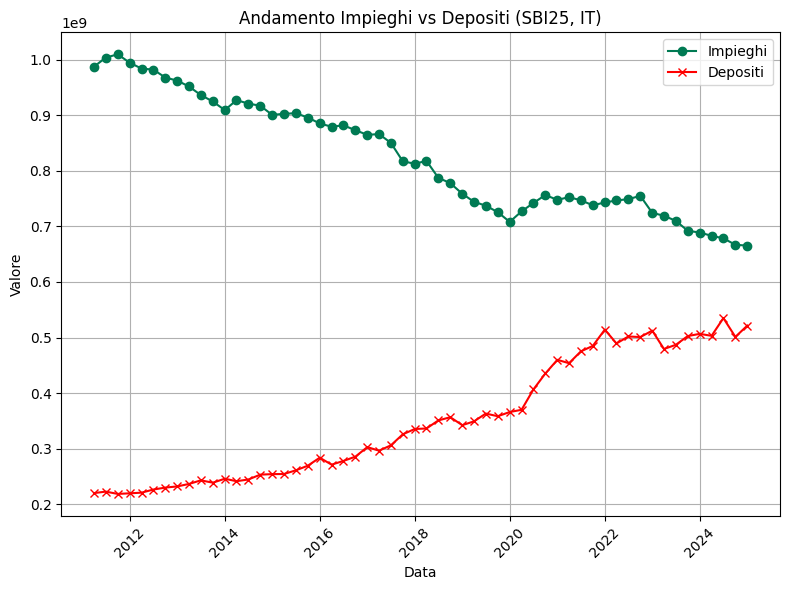

In [83]:
area = 'IT'
set_ctp = 'SBI25' # SBI25, S11, S14BI2, SBI33
# impieghi ['SBI25', 'S11', 'S14BI2', 'S13', 'S12BI7', '600', 'SBI42', 'SBI33']
# depositi ['600', 'SBI42', 'SBI33', 'S13', 'S12BI7', 'SBI25', 'S14BI2', 'S11']
impieghi = pd.read_sql(f"""select DATA_OSS, valore from TFR20232C where SET_CTP='{set_ctp}' and LOC_CTP= '{area}' and ATECO_CTP = '1004999' order by 1""", sqlite)
depositi = pd.read_sql(f"""select DATA_OSS, valore from TFR20269C where SET_CTP='{set_ctp}' and LOC_CTP= '{area}' and FENEC = '52000100' order by 1""", sqlite)
impieghi['DATA_OSS'] = pd.to_datetime(impieghi['DATA_OSS'])
depositi['DATA_OSS'] = pd.to_datetime(depositi['DATA_OSS'])

impieghi = impieghi.rename(columns={'VALORE': 'Impieghi'})
depositi = depositi.rename(columns={'VALORE': 'Depositi'})
df_plot = pd.merge(impieghi, depositi, on='DATA_OSS', how='outer').sort_values('DATA_OSS')
title = f"Andamento Impieghi vs Depositi ({set_ctp}, {area})"

plt.figure(figsize=(8, 6))
plt.plot(df_plot['DATA_OSS'], df_plot['Impieghi'], label='Impieghi', marker='o', color = '#007a53')
plt.plot(df_plot['DATA_OSS'], df_plot['Depositi'], label='Depositi', marker='x', color = '#FF0000')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.title(title)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Forbice tra Depositi e Impieghi

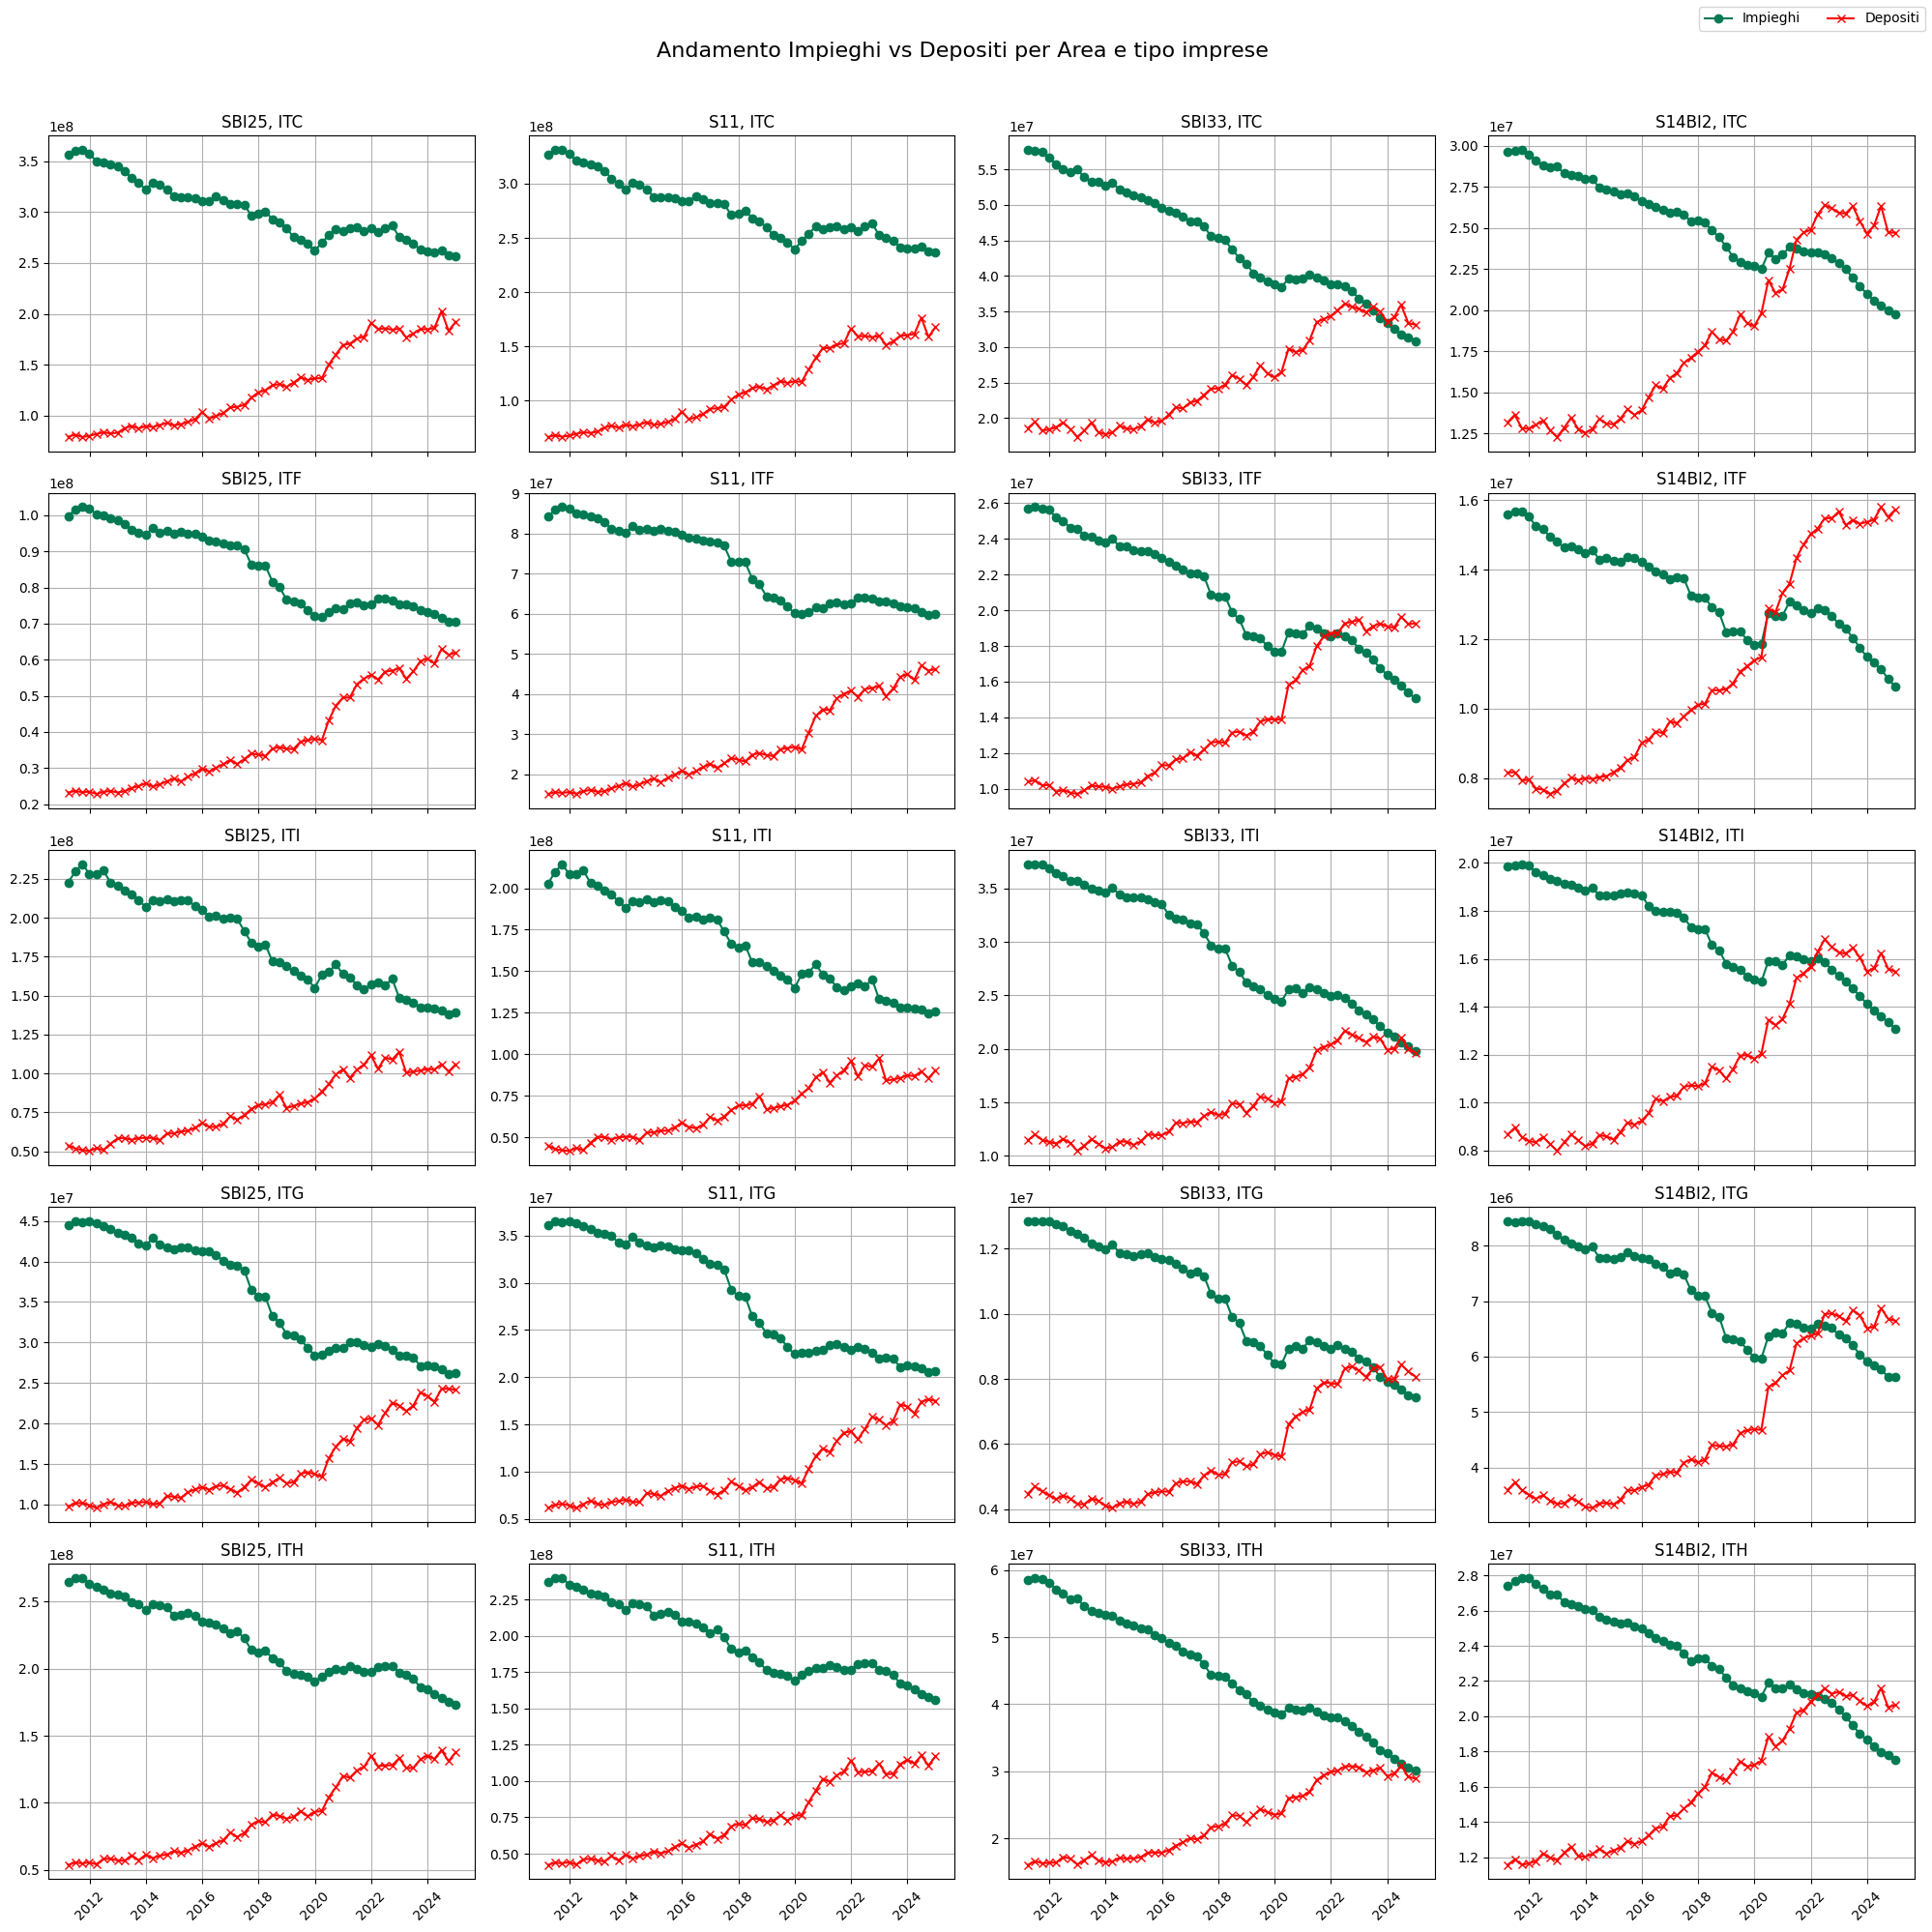

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# === Parametri ===
areas = ['ITC','ITF','ITI','ITG', 'ITH']
set_ctps = ['SBI25', 'S11', 'SBI33', 'S14BI2']

# === Facet settings ===
nrows = len(areas)
ncols = len(set_ctps)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=False)

# === Loop su tutte le combinazioni ===
for (i, area), (j, set_ctp) in product(enumerate(areas), enumerate(set_ctps)):
    ax = axes[i, j] if len(areas) > 1 else axes[j]  # compatibilità 1 riga
    area_str = area
    query_imp = f"""
        SELECT DATA_OSS, VALORE 
        FROM TFR20232C 
        WHERE SET_CTP='{set_ctp}' AND LOC_CTP='{area_str}' AND ATECO_CTP = '1004999'
        ORDER BY DATA_OSS
    """
    query_dep = f"""
        SELECT DATA_OSS, VALORE 
        FROM TFR20269C 
        WHERE SET_CTP='{set_ctp}' AND LOC_CTP='{area_str}' AND FENEC = '52000100'
        ORDER BY DATA_OSS
    """
    
    impieghi = pd.read_sql(query_imp, sqlite)
    depositi = pd.read_sql(query_dep, sqlite)
    
    if impieghi.empty and depositi.empty:
        ax.set_title(f"{set_ctp}, {area} (No data)")
        ax.axis('off')
        continue

    impieghi['DATA_OSS'] = pd.to_datetime(impieghi['DATA_OSS'])
    depositi['DATA_OSS'] = pd.to_datetime(depositi['DATA_OSS'])
    impieghi = impieghi.rename(columns={'VALORE': 'Impieghi'})
    depositi = depositi.rename(columns={'VALORE': 'Depositi'})
    df_plot = pd.merge(impieghi, depositi, on='DATA_OSS', how='outer').sort_values('DATA_OSS')

    ax.plot(df_plot['DATA_OSS'], df_plot['Impieghi'], label='Impieghi', marker='o', color='#007a53')
    ax.plot(df_plot['DATA_OSS'], df_plot['Depositi'], label='Depositi', marker='x', color='#FF0000')
    ax.set_title(f"{set_ctp}, {area}")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

# === Layout e legenda ===
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Andamento Impieghi vs Depositi per Area e tipo imprese", fontsize=16)
plt.savefig("D:/impieghi_vs_depositi_facet.png", dpi=300, bbox_inches='tight')
plt.show()


## Forbice tra Depositi e Impieghi (indice base 100)
la heatmap è basata sulla media dei valori normalizzati (base 100) su tutto il periodo disponibile (es. 2012–2024)

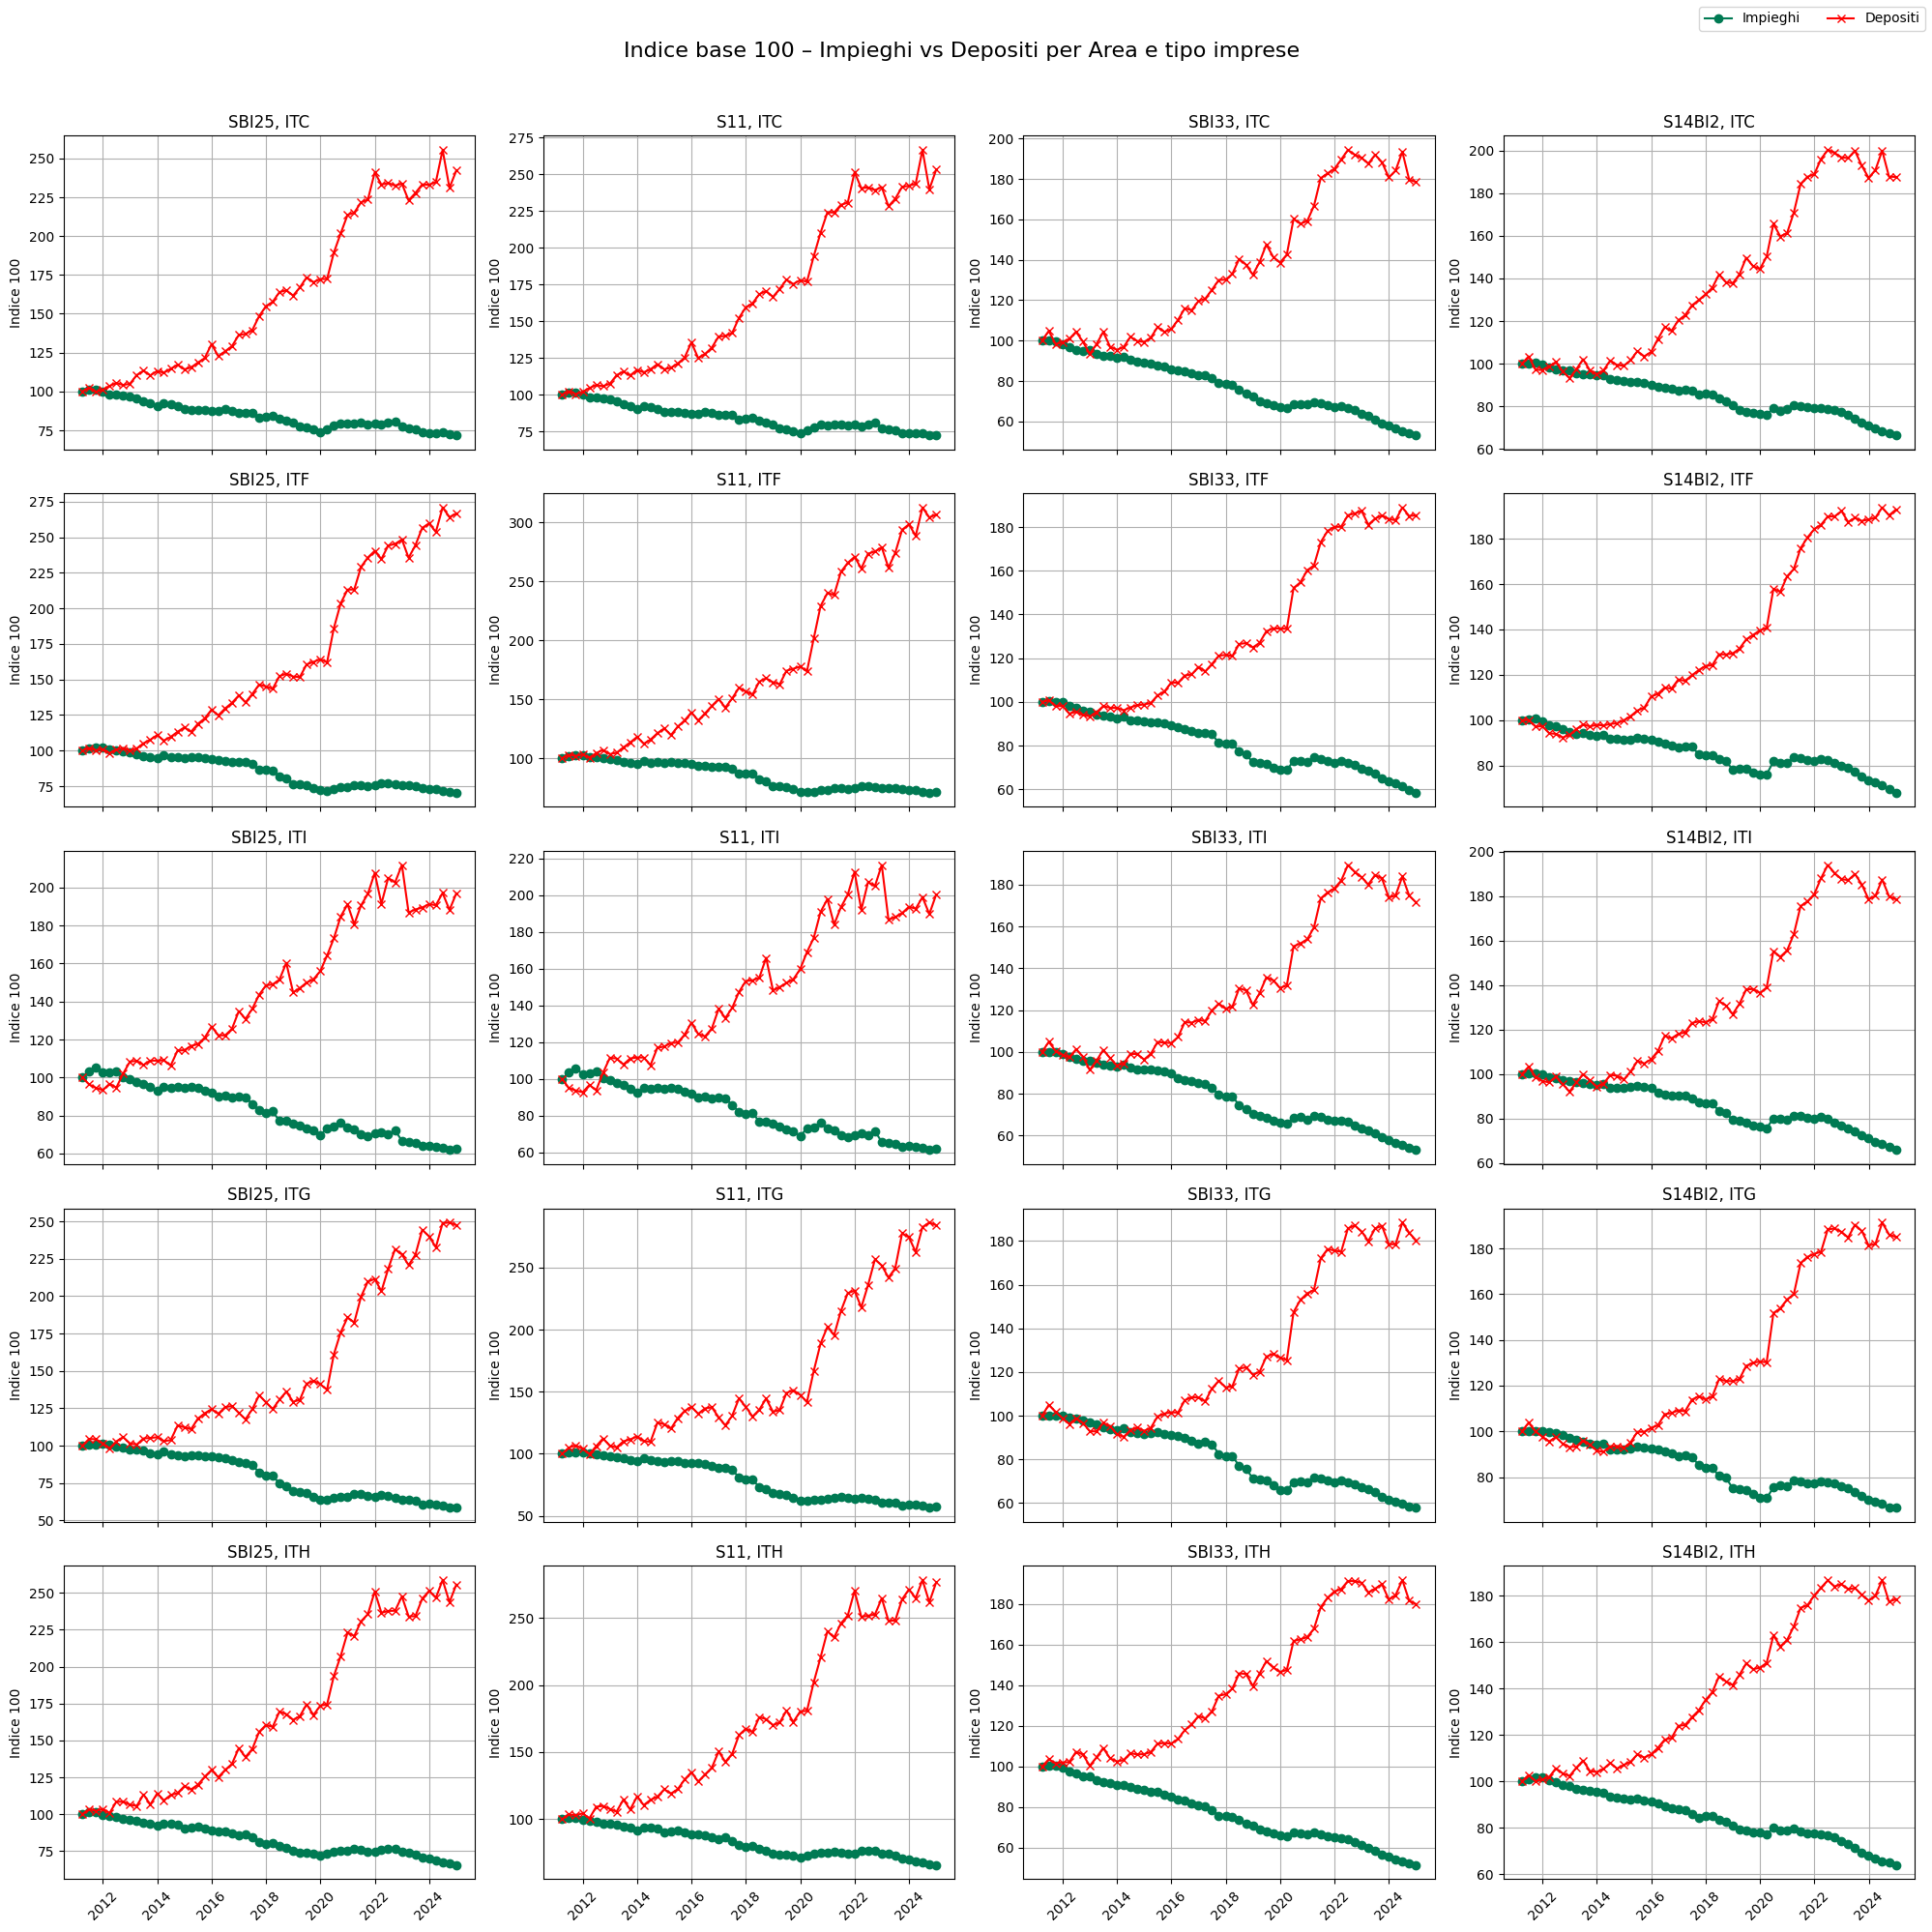

In [82]:
# === Parametri ===
areas = ['ITC','ITF','ITI','ITG', 'ITH']
set_ctps = ['SBI25', 'S11', 'SBI33', 'S14BI2']
indicatori = []

# === Facet plot ===
nrows = len(areas)
ncols = len(set_ctps)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=False)

for i, area in enumerate(areas):
    for j, set_ctp in enumerate(set_ctps):
        ax = axes[i, j]
        query_imp = f"""
            SELECT DATA_OSS, VALORE 
            FROM TFR20232C 
            WHERE SET_CTP='{set_ctp}' AND LOC_CTP='{area}' AND ATECO_CTP = '1004999'
            ORDER BY DATA_OSS
        """
        query_dep = f"""
            SELECT DATA_OSS, VALORE 
            FROM TFR20269C 
            WHERE SET_CTP='{set_ctp}' AND LOC_CTP='{area}' AND FENEC = '52000100'
            ORDER BY DATA_OSS
        """

        impieghi = pd.read_sql(query_imp, sqlite)
        depositi = pd.read_sql(query_dep, sqlite)

        if impieghi.empty and depositi.empty:
            ax.set_title(f"{set_ctp}, {area} (No data)")
            ax.axis('off')
            continue

        impieghi['DATA_OSS'] = pd.to_datetime(impieghi['DATA_OSS'])
        depositi['DATA_OSS'] = pd.to_datetime(depositi['DATA_OSS'])
        impieghi = impieghi.rename(columns={'VALORE': 'Impieghi'})
        depositi = depositi.rename(columns={'VALORE': 'Depositi'})

        df_plot = pd.merge(impieghi, depositi, on='DATA_OSS', how='outer').sort_values('DATA_OSS')

        # Normalizzazione base 100
        start_imp = df_plot['Impieghi'].dropna().iloc[0] if not df_plot['Impieghi'].dropna().empty else 1
        start_dep = df_plot['Depositi'].dropna().iloc[0] if not df_plot['Depositi'].dropna().empty else 1
        df_plot['Impieghi_norm'] = df_plot['Impieghi'] / start_imp * 100
        df_plot['Depositi_norm'] = df_plot['Depositi'] / start_dep * 100

        # === Plot ===
        ax.plot(df_plot['DATA_OSS'], df_plot['Impieghi_norm'], label='Impieghi', marker='o', color='#007a53')
        ax.plot(df_plot['DATA_OSS'], df_plot['Depositi_norm'], label='Depositi', marker='x', color='#FF0000')
        ax.set_title(f"{set_ctp}, {area}")
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel("Indice 100")
        ax.grid(True)

        # === Salva indicatori sintetici ===
        imp_mean = df_plot['Impieghi_norm'].mean()
        dep_mean = df_plot['Depositi_norm'].mean()
        indicatori.append({
            'area': area,
            'set_ctp': set_ctp,
            'impieghi_base100': imp_mean,
            'depositi_base100': dep_mean,
            'forbice': dep_mean - imp_mean,
            'intermediazione': imp_mean / dep_mean if dep_mean else None
        })

# === Layout e salvataggio facet ===
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Indice base 100 – Impieghi vs Depositi per Area e tipo imprese", fontsize=16)
plt.savefig("D:/impieghi_vs_depositi_base100_facet.png", dpi=300, bbox_inches='tight')
plt.show()

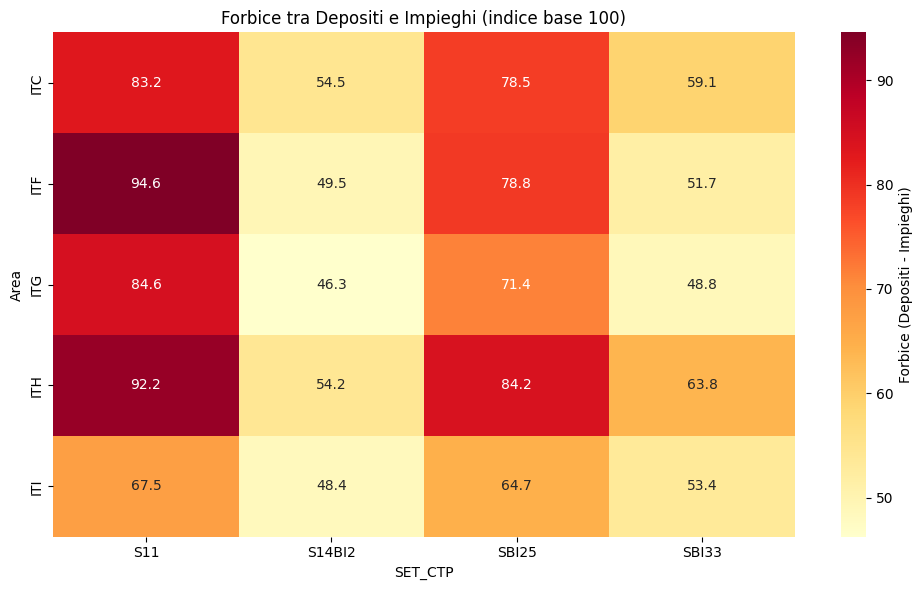

In [81]:
# === Indicatori sintetici: tabella + heatmap ===
df_ind = pd.DataFrame(indicatori)
df_ind.to_csv("D:/indicatori_sintetici_impieghi_vs_depositi.csv", index=False)

# === Heatmap della forbice ===
pivot_forbice = df_ind.pivot(index='area', columns='set_ctp', values='forbice')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_forbice, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Forbice (Depositi - Impieghi)'})
plt.title("Forbice tra Depositi e Impieghi (indice base 100)")
plt.ylabel("Area")
plt.xlabel("SET_CTP")
plt.tight_layout()
plt.savefig("D:/heatmap_forbice_impieghi_vs_depositi.png", dpi=300)
plt.show()

## backup

In [27]:
tabella = 'TFR20232C'
data = pd.read_sql_table(tabella, 'sqlite:///D:/files//Bankit.sqlite')

In [30]:
tabella = 'TFR20269C'
data = pd.read_sql_table(tabella, 'sqlite:///D:/files//Bankit.sqlite')

In [31]:
data['SET_CTP'].unique()

array(['600', 'SBI42', 'SBI33', 'S13', 'S12BI7', 'SBI25', 'S14BI2', 'S11'],
      dtype=object)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converto DATA_OSS in datetime (se necessario)
impieghi['DATA_OSS'] = pd.to_datetime(impieghi['DATA_OSS'])

# Ordino per data crescente
impieghi = impieghi.sort_values(by='DATA_OSS')

# Line plot
plt.figure(figsize=(10, 5))
plt.plot(impieghi['DATA_OSS'], impieghi['VALORE'], marker='o', color = '#007a53')
plt.title('TFR20232 - Evoluzione degli impieghi alle imprese')
plt.xlabel('Data di Osservazione')
plt.ylabel('Valore')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

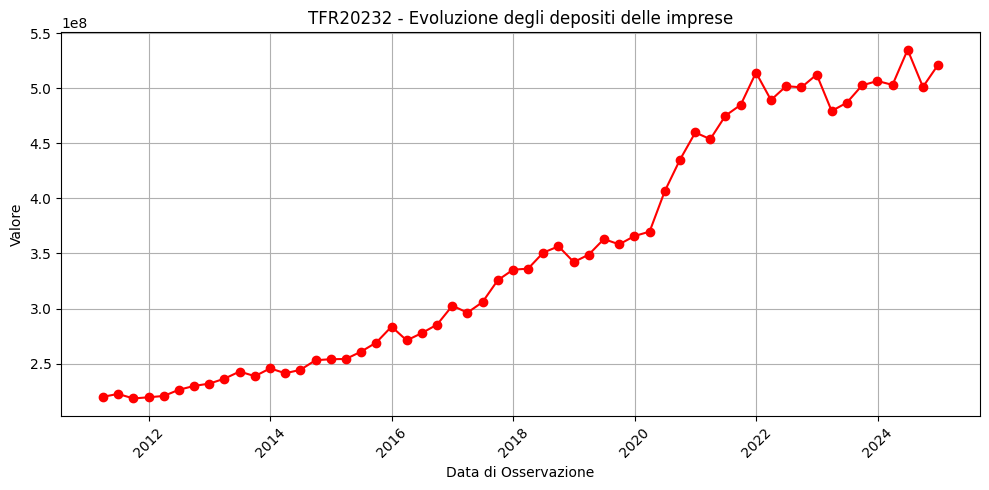

In [11]:
# Converto DATA_OSS in datetime (se necessario)
depositi['DATA_OSS'] = pd.to_datetime(depositi['DATA_OSS'])
plt.figure(figsize=(10, 5))
plt.plot(depositi['DATA_OSS'], depositi['VALORE'], marker='o', color = '#FF0000')
plt.title('TFR20232 - Evoluzione degli depositi delle imprese')
plt.xlabel('Data di Osservazione')
plt.ylabel('Valore')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()